In [5]:
import functools
import scipy as sp
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
import time
% matplotlib inline
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed
import math

In [16]:
def euclidean(p1,p2):
    diff = np.subtract(p1,p2)
    dist = np.linalg.norm(diff)
    return dist
def iso_cov(phi, p1, p2):
    """a function that returns the correlation
    between two oned points"""
    sigma = 1
    dist = euclidean(p1,p2)
    return sigma**2 * np.exp(-dist/phi)
def aniso2d_cov(phi,factor, p1, p2):
    sigma = 1
    dist0 = euclidean(p1[0],p2[0])
    dist1 = euclidean(p1[1],p2[1])
    phi2 = phi*factor
    expon = math.sqrt((dist0/phi)**2 + (dist1/phi2)**2)
    return sigma**2 * np.exp(-expon)
@timeit
def form_cov_matrix(list_of_points, covfun):
    """given a list of points """
    npoints = len(list_of_points)
    mat = np.zeros((npoints, npoints))
    allcombs = itertools.product(enumerate(list_of_points), enumerate(list_of_points))
    for (i, elementi), (j,elementj) in allcombs:
            mat[i,j] = covfun(elementi, elementj)
    return mat
    
@timeit
def simulate(covmatrix):
    """given a covariance matrix perform the
    cholesky decomposition to find lower triangular L
    such that L*L^H = covmatrix, then multiply L by a 
    vector of zero mean unit variance random normal
    numbers to return a realisation of the random process"""
    n,n = np.shape(covmatrix)
    print(n,n)
    L = np.linalg.cholesky(covmatrix)#nxn triangular matrix
    rands = np.random.normal(size = (n,1))
    sim = L @ rands
    return sim

### Test 1D case

In [17]:
vector = range(50)
volatilecov = functools.partial(iso_cov, 0.1)
smoothcov = functools.partial(iso_cov, 20)
volatile_field = simulate(form_cov_matrix(vector, volatilecov))
smooth_field = simulate(form_cov_matrix(vector, smoothcov))

'form_cov_matrix'  136.00 ms
50 50
'simulate'  2.46 ms
'form_cov_matrix'  56.48 ms
50 50
'simulate'  0.61 ms


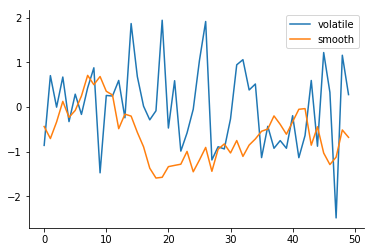

In [82]:
fig, ax = plt.subplots(1)
ax.plot(volatile_field, label = 'volatile')
ax.plot(smooth_field, label = 'smooth')
ax.legend()
sns.despine()

### Now test 2D case

In [75]:
@timeit
def twod_grid(n, size=1):
    """given a size, generate a list of pairs of coordinates
    corresponding with grid points on a sizexsize grid"""
    xs = ys = np.arange(start=0,stop=int(n*size), step=size)
    return list(itertools.product(xs, ys))
def plot(original,twod):
    df = pd.DataFrame(original, columns=['row','col'])
    df['values'] = twod
    mat = df.pivot('row','col', 'values')
    ax = sns.heatmap(mat)
    return ax
square = twod_grid(20)
volatile_2d = simulate(form_cov_matrix(square, volatilecov))
smooth_2d = simulate(form_cov_matrix(square, smoothcov))

    

'twod_grid'  0.08 ms
'form_cov_matrix'  4328.61 ms
400 400
'simulate'  7.55 ms
'form_cov_matrix'  4191.08 ms
400 400
'simulate'  8.39 ms


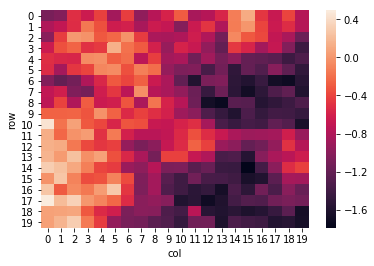

In [78]:
ax1 = plot(square, smooth_2d)

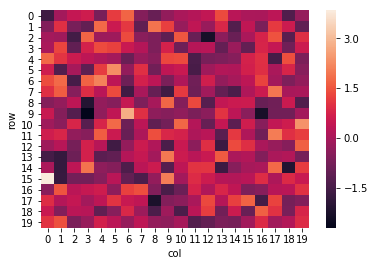

In [79]:
ax2 = plot(square, volatile_2d)

### Simple 2D anisotropy

In [104]:
scov = functools.partial(aniso2d_cov, 0.1, 50)
vcov = functools.partial(aniso2d_cov, 5, 50)
volatile_aniso2d = simulate(form_cov_matrix(square, scov))
smooth_aniso2d = simulate(form_cov_matrix(square, vcov))

'form_cov_matrix'  6577.34 ms
400 400
'simulate'  6.86 ms
'form_cov_matrix'  6643.48 ms
400 400
'simulate'  6.64 ms


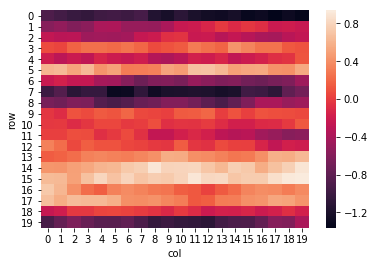

In [105]:
plot(square, smooth_aniso2d)

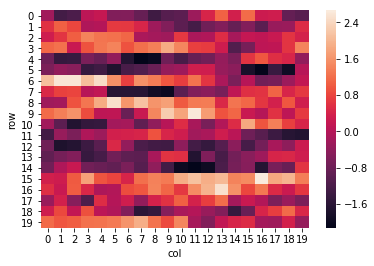

In [106]:
plot(square, volatile_aniso2d)

In [265]:
def fftIndgen(n):
    a = list(range(0, int(n/2+1)))
    b = list(reversed(range(1, int(n/2))))
    b = [-i for i in b]
    return a + b
def power_spectrum(alpha,k):
    fourier = lambda k: 2*alpha/(alpha**2+(k**2))
    if k == 0:
        return 0
    return fourier(k)
def power_spectrum2d(alpha, kx,ky):
    scale = 50
    fourier = lambda k: 2*alpha/(alpha**2+(k**2))
    if kx == 0 and ky==0:
        return 0
    k = np.sqrt(kx**2+ky**2)
    return fourier(np.sqrt(kx**2+scale*ky**2))
def gaussian_proc(psd_fun, size=1024):
    noise = np.fft.fft(np.random.normal(size = size))
    amplitude = np.zeros(size)
    for i,kx in enumerate(fftIndgen(size)):
        amplitude[i] = psd_fun(kx)
    return np.fft.ifft(noise*amplitude)
def gaussian_random_field(Pk = lambda k : k**-10.0, size = 30):
    def Pk3(kx, ky,kz):
        if kx == 0 and ky == 0 and kz==0:
            return 0.0
        return np.sqrt(Pk(np.sqrt(kx**2 + ky**2+ (5*kz)**2)))
    noise = np.fft.fftn(np.random.normal(size = (size, size,365*24)))
    amplitude = np.zeros((size,size, 365*24))
    for i, kx in enumerate(fftIndgen(size)):
        for j, ky in enumerate(fftIndgen(size)):
            for z, kz in enumerate(fftIndgen(365*24)):
                amplitude[i, j,z] = Pk3(kx, ky, kz)
    return np.fft.ifftn(noise * amplitude)
def gaussian_field_alt(psd_fun, size=100):
    noise = np.fft.fft2(np.random.normal(size = (size, size)))
    amplitude = np.zeros((size,size))
    for i, kx in enumerate(fftIndgen(size)):
        for j, ky in enumerate(fftIndgen(size)):            
            amplitude[i, j] = psd_fun(kx, ky)
    return np.fft.ifft2(noise * amplitude)

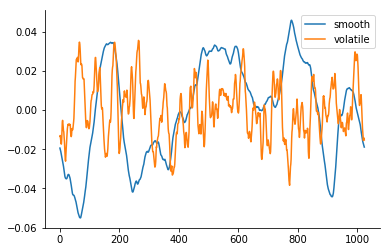

In [188]:
volatile_res = gaussian_proc(functools.partial(power_spectrum, 30))
smooth_res = gaussian_proc(functools.partial(power_spectrum, 3))
fig,ax = plt.subplots(1)
ax.plot(smooth_res.real, label = 'smooth')
ax.plot(volatile_res.real, label= 'volatile')
ax.legend()
sns.despine()

In [270]:
res = gaussian_random_field()
sns.heatmap(res.real[:,:,15])

KeyboardInterrupt: 

In [ ]:
noise = np.fft.fftn(np.random.normal(size = (50, 50,365*24)))
a = np.fft.ifftn(noise)

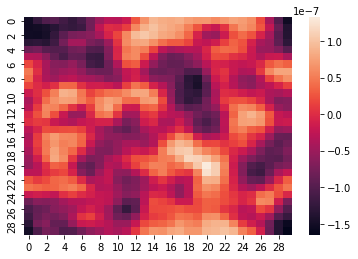

In [264]:
sns.heatmap(res.real[:,:,11]-res.real[:,:,12])

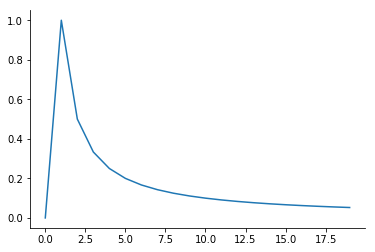

In [14]:
somenoise = 

/home/jjlong/continuous/venv/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


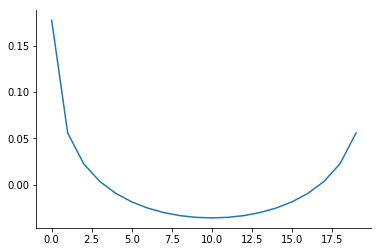

In [15]:
invpsd = np.fft.ifft(psd)
fig, ax = plt.subplots(1)
ax.plot([i for i in invpsd])
sns.despine()

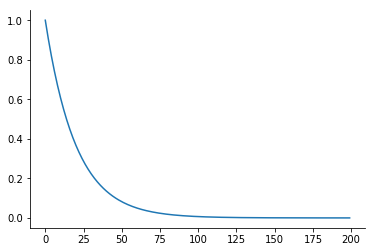

In [20]:
expcorr = [smoothcov(i,0) for i in range(200)]
psd = np.fft.fft(expcorr)
fig, ax = plt.subplots(1)
ax.plot([i for i in expcorr])
sns.despine()

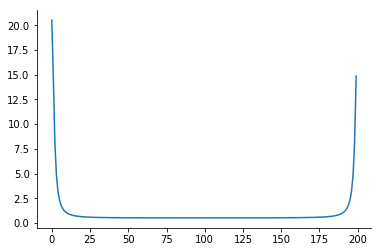

In [25]:
fig, ax = plt.subplots(1)
ax.plot([i for i in psd.real])
sns.despine()

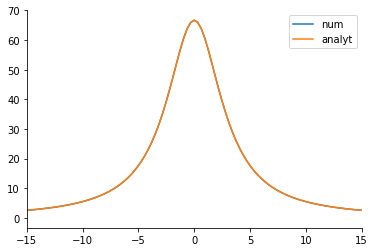

In [132]:
fig,ax = plt.subplots(1)
ts = np.linspace(-10, 10, 2001)
dt = ts[1] - ts[0]
normalization = 1 / dt
ks = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(ts.shape[0], d=dt))
alpha = 3
signal = lambda t: np.exp(-alpha*np.abs(t))
fourier = lambda k: 2*alpha/(alpha**2+(k**2))
#ax.plot(ac)
numerical = np.fft.fftshift(np.fft.fft([signal(t) for t in ts]))
analytical = np.array([fourier(k) for k in ks])
#ax.plot(np.fft.ifft(numerical))
#ax.plot(np.fft.ifft(analytical))
#ax.plot(numerical)
ax.plot(ks,np.absolute(numerical), label = 'num')
ax.plot(ks, normalization*np.absolute(analytical), label='analyt')
ax.set_xlim([-15,15])
sns.despine()
ax.legend()


/home/jjlong/continuous/venv/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


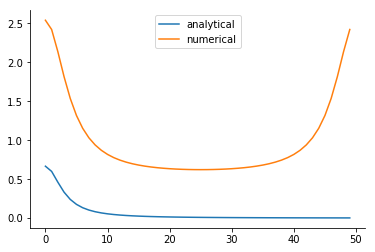

In [71]:
fig,ax = plt.subplots(1)
ax.plot([fourier(i) for i in range(50)], label = 'analytical')
numerical = np.fft.fft(ac)
ax.plot(numerical, label='numerical')
ax.legend()
sns.despine()